**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
import importlib.metadata
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from diive.core.io.files import save_parquet

sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.core.io.files import load_parquet
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.87.0
dbc-influxdb version: v0.13.1
Reading configuration files was successful.
Connection to database works.


</br>

# **LOAD DATA** from files

In [3]:
file_meteo_2021_2024 = "12.1_CH-CHA_DATABASE_meteo_2021-2024.parquet"
df_2021_2024 = load_parquet(filepath=file_meteo_2021_2024)
df_2021_2024

Loaded .parquet file 12.1_CH-CHA_DATABASE_meteo_2021-2024.parquet (0.054 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,G_GF1_0.06_1,G_GF1_0.06_2,LW_IN_T1_1_1,LW_OUT_T1_1_1,PPFD_IN_T1_2_1,PPFD_OUT_T1_2_1,...,TS_GF1_0.4_2,TS_GF1_0.5_2,TS_GF1_0.6_2,TS_GF1_0.75_2,TS_GF1_0.95_1,TS_GF1_1_2
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2021-01-01 00:15:00,-6.887082,-8.630404,285.659340,292.033183,0.0,0.0,...,NaN,3.491056,NaN,NaN,4.505392,5.140111
2021-01-01 00:45:00,-6.881727,-8.593153,276.304473,289.757377,0.0,0.0,...,NaN,3.490172,NaN,NaN,4.501024,5.142586
2021-01-01 01:15:00,-6.860665,-8.571210,266.556937,282.779523,0.0,0.0,...,NaN,3.489630,NaN,NaN,4.498686,5.148580
2021-01-01 01:45:00,-6.850413,-8.579524,283.767490,288.579233,0.0,0.0,...,NaN,3.490111,NaN,NaN,4.497496,5.136444
2021-01-01 02:15:00,-6.840737,-8.568706,288.668837,292.348167,0.0,0.0,...,NaN,3.490333,NaN,NaN,4.494951,5.141333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,-6.896756,-6.284012,227.565077,265.189837,0.0,0.0,...,3.293897,3.919832,4.228588,4.476450,4.700538,5.240322
2024-12-31 22:15:00,-6.897304,-6.290326,227.376887,264.182430,0.0,0.0,...,3.297842,3.920494,4.229919,4.471778,4.700398,5.245044
2024-12-31 22:45:00,-6.897327,-6.346511,226.851997,266.966060,0.0,0.0,...,3.292583,3.913211,4.228589,4.473780,4.699080,5.242346


In [4]:
file_meteo_2005_2020 = "12.3_CH-CHA_DATABASE_meteo_2005-2020.parquet"
df_2005_2020 = load_parquet(filepath=file_meteo_2005_2020)
df_2005_2020

Loaded .parquet file 12.3_CH-CHA_DATABASE_meteo_2005-2020.parquet (0.055 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,G_GF1_0.03_1,G_GF1_0.03_2,G_GF1_0.03_3,G_GF1_0.03_4,G_GF1_0.06_1,G_GF1_0.06_2,...,TS_GF1_0.2_2,TS_GF1_0.3_2,TS_GF1_0.4_1,TS_GF1_0.5_2,TS_GF1_0.95_1,TS_GF1_1_2
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-07-26 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:45:00,NaN,NaN,NaN,NaN,-6.953937,-8.758601,...,2.217611,2.737444,3.163623,3.495778,4.511497,5.161611
2020-12-31 22:15:00,NaN,NaN,NaN,NaN,-6.946144,-8.768112,...,2.216278,2.735056,3.162629,3.492722,4.508283,5.160667
2020-12-31 22:45:00,NaN,NaN,NaN,NaN,-6.934731,-8.742898,...,2.214167,2.734944,3.159903,3.492111,4.507120,5.159500


</br>

# **Merge data**

In [5]:
# Merge data on index
df_merged_2005_2024 = pd.concat([df_2005_2020, df_2021_2024], axis=0)
df_merged_2005_2024

,G_GF1_0.03_1,G_GF1_0.03_2,G_GF1_0.03_3,G_GF1_0.03_4,G_GF1_0.06_1,G_GF1_0.06_2,...,SWC_GF1_0.75_2,SW_IN_T1_1_1,SW_OUT_T1_1_1,TS_GF1_0.4_2,TS_GF1_0.6_2,TS_GF1_0.75_2
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-07-26 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,NaN,NaN,NaN,NaN,-6.896756,-6.284012,...,39.417983,0.0,0.0,3.293897,4.228588,4.476450
2024-12-31 22:15:00,NaN,NaN,NaN,NaN,-6.897304,-6.290326,...,39.438157,0.0,0.0,3.297842,4.229919,4.471778
2024-12-31 22:45:00,NaN,NaN,NaN,NaN,-6.897327,-6.346511,...,39.390667,0.0,0.0,3.292583,4.228589,4.473780


</br>

## Sanitize timestamp

In [6]:
df_merged_2005_2024 = TimestampSanitizer(data=df_merged_2005_2024, output_middle_timestamp=False).get()
df_merged_2005_2024

,G_GF1_0.03_1,G_GF1_0.03_2,G_GF1_0.03_3,G_GF1_0.03_4,G_GF1_0.06_1,G_GF1_0.06_2,...,SWC_GF1_0.75_2,SW_IN_T1_1_1,SW_OUT_T1_1_1,TS_GF1_0.4_2,TS_GF1_0.6_2,TS_GF1_0.75_2
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-07-26 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-26 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,NaN,NaN,NaN,NaN,-6.896756,-6.284012,...,39.417983,0.0,0.0,3.293897,4.228588,4.476450
2024-12-31 22:15:00,NaN,NaN,NaN,NaN,-6.897304,-6.290326,...,39.438157,0.0,0.0,3.297842,4.229919,4.471778
2024-12-31 22:45:00,NaN,NaN,NaN,NaN,-6.897327,-6.346511,...,39.390667,0.0,0.0,3.292583,4.228589,4.473780


</br>

## Sort columns to identify vars that can be combined

In [7]:
df_merged_2005_2024 = df_merged_2005_2024.reindex(sorted(df_merged_2005_2024.columns), axis=1)
[print(c) for c in df_merged_2005_2024.columns];

G_GF1_0.03_1
G_GF1_0.03_2
G_GF1_0.03_3
G_GF1_0.03_4
G_GF1_0.06_1
G_GF1_0.06_2
LW_IN_T1_1_1
LW_IN_T1_2_1
LW_OUT_T1_1_1
LW_OUT_T1_2_1
PPFD_IN_CORRECTED_T1_2_1
PPFD_IN_T1_2_1
PPFD_OUT_T1_2_1
PREC_TOT_FIXED_M1_1_2
PREC_TOT_GF1_1_1
PREC_TOT_M1_1_1
PREC_TOT_T1_0.5_1
RH_T1_2_1
SWC_GF1_0.05_1
SWC_GF1_0.05_2
SWC_GF1_0.15_1
SWC_GF1_0.1_2
SWC_GF1_0.25_1
SWC_GF1_0.2_2
SWC_GF1_0.3_2
SWC_GF1_0.4_1
SWC_GF1_0.4_2
SWC_GF1_0.5_2
SWC_GF1_0.6_2
SWC_GF1_0.75_1
SWC_GF1_0.75_2
SWC_GF1_0.95_1
SWC_GF1_1_2
SW_IN_CORRECTED_T1_2_1
SW_IN_T1_1_1
SW_OUT_T1_1_1
SW_OUT_T1_2_1
TA_T1_2_1
TS_GF1_0.01_1
TS_GF1_0.02_1
TS_GF1_0.04_1
TS_GF1_0.05_2
TS_GF1_0.07_1
TS_GF1_0.15_1
TS_GF1_0.1_1
TS_GF1_0.1_2
TS_GF1_0.25_1
TS_GF1_0.2_2
TS_GF1_0.3_2
TS_GF1_0.4_1
TS_GF1_0.4_2
TS_GF1_0.5_2
TS_GF1_0.6_2
TS_GF1_0.75_2
TS_GF1_0.95_1
TS_GF1_1_2


</br>

## Combine variables

In [8]:
# SW_IN
df_merged_2005_2024['SW_IN_T1_1_1'] = df_merged_2005_2024['SW_IN_T1_1_1'].fillna(df_merged_2005_2024['SW_IN_CORRECTED_T1_2_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop('SW_IN_CORRECTED_T1_2_1', axis=1)

# SW_OUT
df_merged_2005_2024['SW_OUT_T1_1_1'] = df_merged_2005_2024['SW_OUT_T1_1_1'].fillna(df_merged_2005_2024['SW_OUT_T1_2_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop('SW_OUT_T1_2_1', axis=1)

# LW_IN
df_merged_2005_2024['LW_IN_T1_1_1'] = df_merged_2005_2024['LW_IN_T1_1_1'].fillna(df_merged_2005_2024['LW_IN_T1_2_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop('LW_IN_T1_2_1', axis=1)

# LW_OUT
df_merged_2005_2024['LW_OUT_T1_1_1'] = df_merged_2005_2024['LW_OUT_T1_1_1'].fillna(df_merged_2005_2024['LW_OUT_T1_2_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop('LW_OUT_T1_2_1', axis=1)

# PPFD
df_merged_2005_2024['PPFD_IN_T1_2_1'] = df_merged_2005_2024['PPFD_IN_T1_2_1'].fillna(df_merged_2005_2024['PPFD_IN_CORRECTED_T1_2_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop('PPFD_IN_CORRECTED_T1_2_1', axis=1)

# PREC
df_merged_2005_2024['PREC_TOT_GF1_1_1'] = df_merged_2005_2024['PREC_TOT_GF1_1_1'].fillna(df_merged_2005_2024['PREC_TOT_T1_0.5_1'])
df_merged_2005_2024['PREC_TOT_GF1_1_1'] = df_merged_2005_2024['PREC_TOT_GF1_1_1'].fillna(df_merged_2005_2024['PREC_TOT_FIXED_M1_1_2'])
df_merged_2005_2024['PREC_TOT_GF1_1_1'] = df_merged_2005_2024['PREC_TOT_GF1_1_1'].fillna(df_merged_2005_2024['PREC_TOT_M1_1_1'])
df_merged_2005_2024 = df_merged_2005_2024.drop(['PREC_TOT_T1_0.5_1', 'PREC_TOT_FIXED_M1_1_2', 'PREC_TOT_M1_1_1'], axis=1)

[print(c) for c in df_merged_2005_2024.columns];

G_GF1_0.03_1
G_GF1_0.03_2
G_GF1_0.03_3
G_GF1_0.03_4
G_GF1_0.06_1
G_GF1_0.06_2
LW_IN_T1_1_1
LW_OUT_T1_1_1
PPFD_IN_T1_2_1
PPFD_OUT_T1_2_1
PREC_TOT_GF1_1_1
RH_T1_2_1
SWC_GF1_0.05_1
SWC_GF1_0.05_2
SWC_GF1_0.15_1
SWC_GF1_0.1_2
SWC_GF1_0.25_1
SWC_GF1_0.2_2
SWC_GF1_0.3_2
SWC_GF1_0.4_1
SWC_GF1_0.4_2
SWC_GF1_0.5_2
SWC_GF1_0.6_2
SWC_GF1_0.75_1
SWC_GF1_0.75_2
SWC_GF1_0.95_1
SWC_GF1_1_2
SW_IN_T1_1_1
SW_OUT_T1_1_1
TA_T1_2_1
TS_GF1_0.01_1
TS_GF1_0.02_1
TS_GF1_0.04_1
TS_GF1_0.05_2
TS_GF1_0.07_1
TS_GF1_0.15_1
TS_GF1_0.1_1
TS_GF1_0.1_2
TS_GF1_0.25_1
TS_GF1_0.2_2
TS_GF1_0.3_2
TS_GF1_0.4_1
TS_GF1_0.4_2
TS_GF1_0.5_2
TS_GF1_0.6_2
TS_GF1_0.75_2
TS_GF1_0.95_1
TS_GF1_1_2


</br>

## Plot

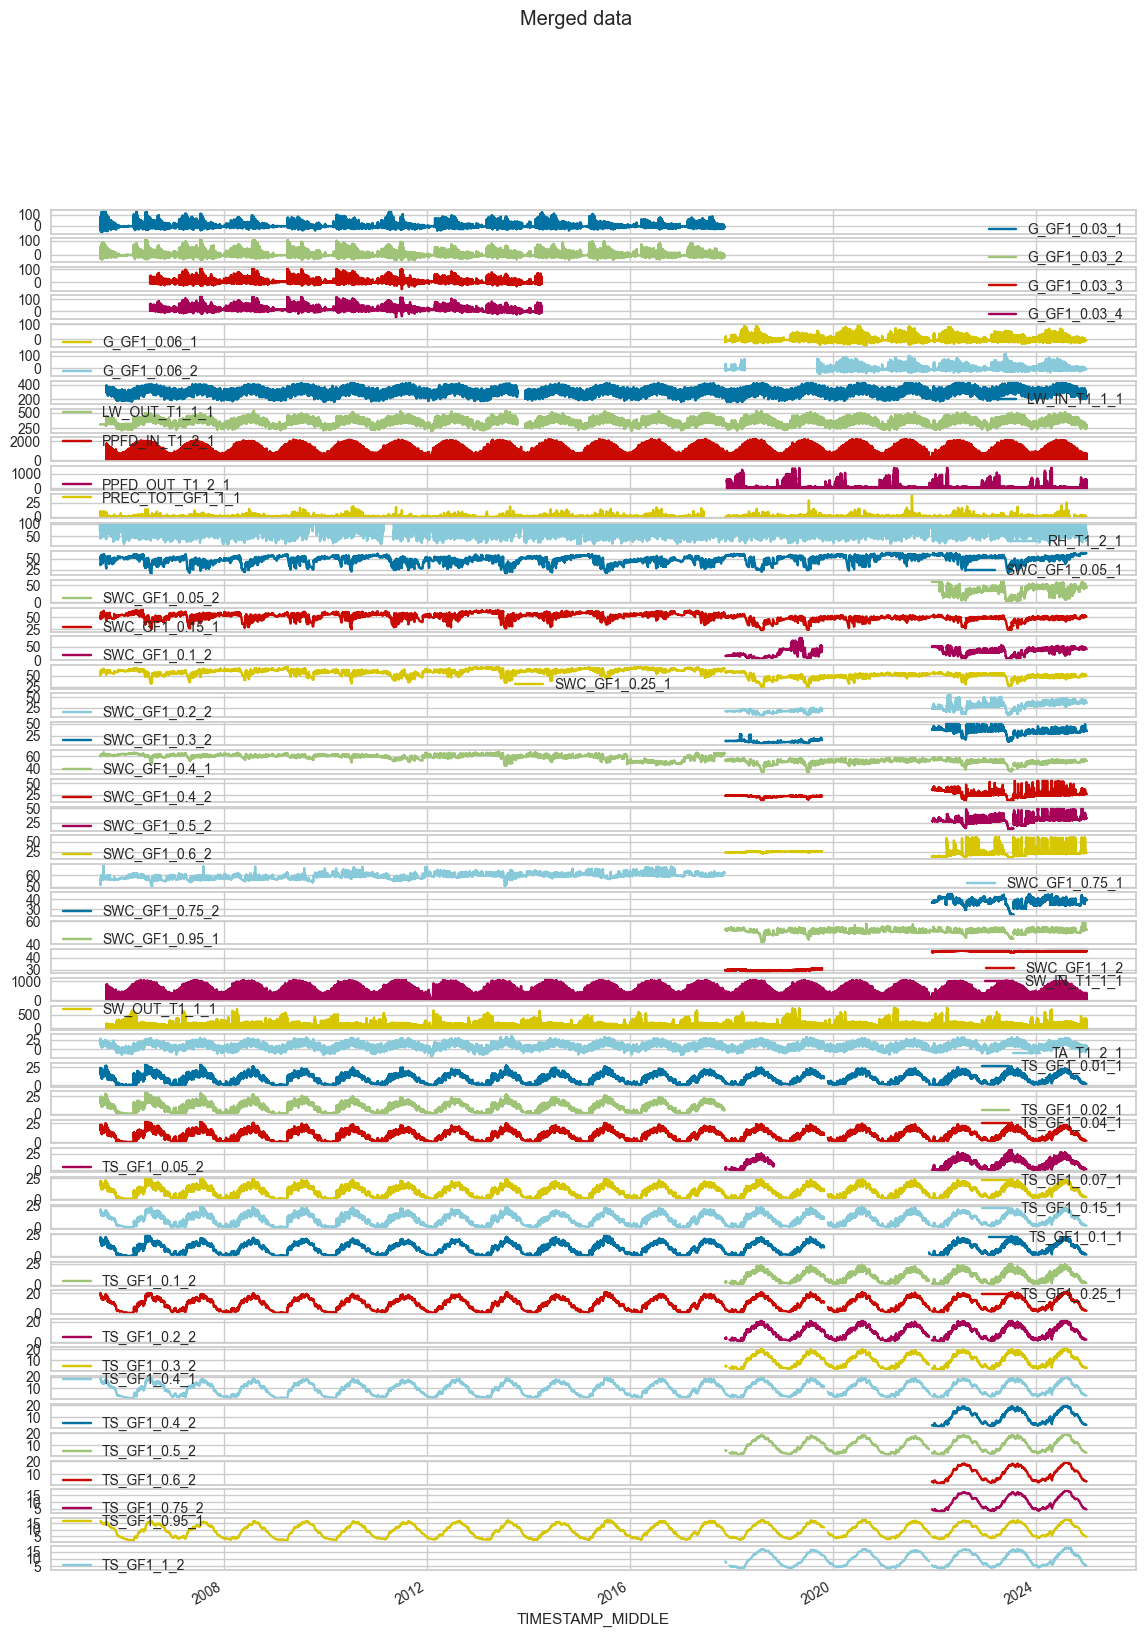

In [9]:
df_merged_2005_2024.plot(subplots=True, x_compat=True, title="Merged data", figsize=(14, 20));

</br>

## Check data types

In [10]:
df_merged_2005_2024.dtypes

G_GF1_0.03_1        float64
G_GF1_0.03_2        float64
G_GF1_0.03_3        float64
G_GF1_0.03_4        float64
G_GF1_0.06_1        float64
G_GF1_0.06_2        float64
LW_IN_T1_1_1        float64
LW_OUT_T1_1_1       float64
PPFD_IN_T1_2_1      float64
PPFD_OUT_T1_2_1     float64
PREC_TOT_GF1_1_1    float64
RH_T1_2_1           float64
SWC_GF1_0.05_1      float64
SWC_GF1_0.05_2      float64
SWC_GF1_0.15_1      float64
SWC_GF1_0.1_2       float64
SWC_GF1_0.25_1      float64
SWC_GF1_0.2_2       float64
SWC_GF1_0.3_2       float64
SWC_GF1_0.4_1       float64
SWC_GF1_0.4_2       float64
SWC_GF1_0.5_2       float64
SWC_GF1_0.6_2       float64
SWC_GF1_0.75_1      float64
SWC_GF1_0.75_2      float64
SWC_GF1_0.95_1      float64
SWC_GF1_1_2         float64
SW_IN_T1_1_1        float64
SW_OUT_T1_1_1       float64
TA_T1_2_1           float64
TS_GF1_0.01_1       float64
TS_GF1_0.02_1       float64
TS_GF1_0.04_1       float64
TS_GF1_0.05_2       float64
TS_GF1_0.07_1       float64
TS_GF1_0.15_1       

</br>

# **SAVE TO FILE**

In [11]:
OUTNAME = "13.1_CH-CHA_meteo_2005-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=df_merged_2005_2024, outpath=OUTPATH)
df_merged_2005_2024.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 13.1_CH-CHA_meteo_2005-2024.parquet (0.627 seconds).


</br>

# **End of notebook**.

In [12]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-04-21 20:24:21
